In [76]:
import pandas as pd
%matplotlib inline

In [8]:
df911 = pd.read_csv('raw/911_Police_Calls_for_Service.csv', sep=';')

In [9]:
df911.head()

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,1423624,05/04/2016 09:58:00 PM,High,ND,SILENT ALARM,P161253035,400 WINSTON AV,"400 WINSTON AV\nBALTIMORE, MD\n(39.349792, -76..."
1,1402097,04/27/2016 03:57:00 PM,Medium,SW,911/HANGUP,P161182081,1400 BRADDISH AV,"1400 BRADDISH AV\nBALTIMORE, MD\n(39.303941, -..."
2,1420176,05/03/2016 06:40:00 PM,Medium,ED,DISORDERLY,P161242705,200 E NORTH AV,"200 E NORTH AV\nBALTIMORE, MD\n(39.311294, -76..."
3,1423653,05/04/2016 10:10:00 PM,Medium,NE,911/NO VOICE,P161253068,2500-1 HARFORD RD,"2500 1 HARFORD RD\nBALTIMORE, MD\n(39.316763, ..."
4,1417949,05/03/2016 12:29:00 AM,Non-Emergency,SD,Private Tow,P161240063,100 W PATAPSCO AV,"100 W PATAPSCO AV\nBALTIMORE, MD\n(39.239215, ..."


In [10]:
df911.shape

(3242420, 8)

# preprocessing

In [14]:
# fillna
df911.priority.fillna('NaN', inplace=True)
df911.description.fillna('NaN', inplace=True)
df911.location.fillna('NaN', inplace=True)

In [42]:
def extract_coords(x):
    x=x.strip()
    if x is None:
        return None
    try:
        coords = eval(x.split('\n')[-1])
    except (NameError, SyntaxError):
        return None
    if isinstance(coords, tuple):
        return coords
    return None

In [43]:
# extract location
df911['coords'] = df911.location.apply(extract_coords)

In [53]:
df911['Latitude'] = df911.coords.apply(lambda x: x[0] if x is not None else None)
df911['Longitude'] = df911.coords.apply(lambda x: x[1] if x is not None else None)

In [65]:
df911['date'] = df911.callDateTime.apply(lambda x: x[:10])
df911['date'] = pd.to_datetime(df911['date'], format='%m/%d/%Y')

# categorical variable counts

In [92]:
priority = df.priority.value_counts().to_frame()
priority.priority.sum()

3242420

In [95]:
priority_types = ['Low', 'Medium', 'High', 'Non-Emergency', 'Emergency', 'Out of Service']

In [16]:
description = df.description.value_counts().to_frame()

In [18]:
description['percentage'] = description.description/description.description.sum()

In [21]:
# description.to_csv('tmp-911-description.csv')
description.shape

(8810, 2)

In [96]:
description_types = ['DISORDERLY', 'COMMON ASSAULT', 'NARCOTICSOutside', 'SILENT ALARM', 'FAMILY DISTURB', 'BURGLARY']

# Time series

In [113]:
min_date = df911['date'].min()
max_date = df911['date'].max()
temporal_df = pd.DataFrame(index=pd.date_range(min_date, max_date))
date_col = 'date'

In [114]:
temporal_df = temporal_df.join(df911.groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col: 'ALL'}))

In [115]:
col = 'priority'
for t in priority_types:
    temporal_df = temporal_df.join(
        df911[df911[col]==t].groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col:col+'-'+t}))

In [116]:
col = 'description'
for t in description_types:
    temporal_df = temporal_df.join(
        df911[df911[col]==t].groupby(date_col).agg({date_col: 'count'}).rename(columns={date_col:col+'-'+t}))

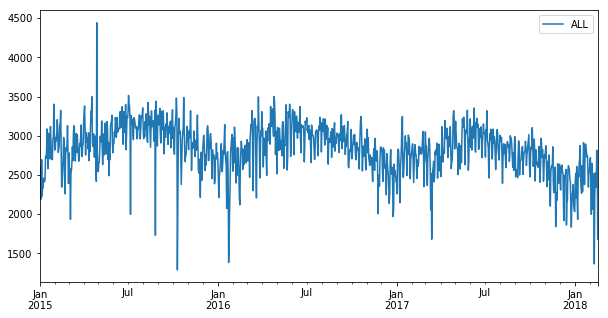

In [119]:
temporal_df[['ALL']].plot(figsize=(10,5))

time series


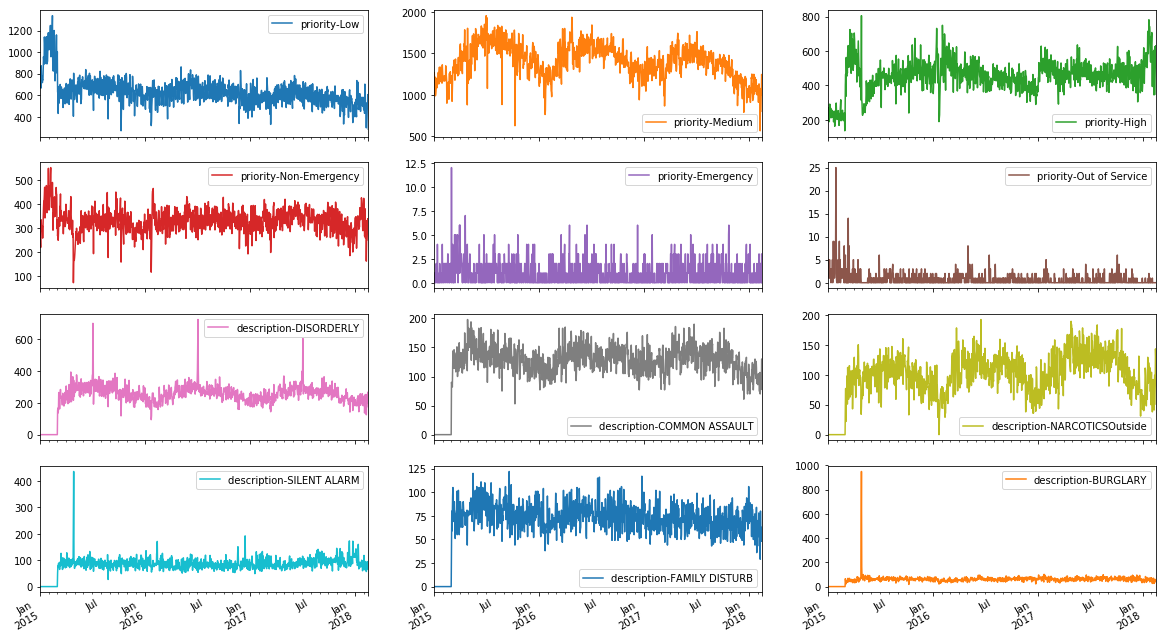

In [118]:
temporal_df.drop('ALL', axis=1).fillna(0).plot(subplots=True, layout=(5,3), figsize=(20,15))
print('time series')

# grid

In [120]:
from shapely.geometry import Point, box
import geopandas as gp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot

In [121]:

def grid_line(mini, maxi, ngrid=10):
    delta = (maxi - mini) / ngrid
    return [(mini + i * delta, mini + (i + 1) * delta) for i in range(ngrid)]


def grid_area(w, s, e, n, ngrid=10):
    """
    grid area into ngrid^2 grids
    :param w, s, e, n,: the w, s, e, n (min_lon, min_lat, max_lon, max_lat) of the bound box
    :param ngrid: divide area into ngrid^2 grids
    :return: list of grid represented by bound box with s,w,n,e
    """
    grid_lat = grid_line(s, n, ngrid)
    grid_lon = grid_line(w, e, ngrid)
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            si, ni = grid_lat[i]
            wj, ej = grid_lon[j]
            grids.append((wj, si, ej, ni))
    return grids

In [122]:
cityline = gp.read_file('raw/Baltcity_Line/baltcity_line.shp')
cityline.to_crs(epsg=3559, inplace=True)

In [125]:
gpdf_911 = df911[['Longitude', 'Latitude', 'priority', 'description']]
gpdf_911 = gpdf_911[~gpdf_911.Longitude.isnull()]
gpdf_911['geometry'] = gpdf_911.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
gpdf_911 = gp.GeoDataFrame(gpdf_911.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'})
gpdf_911.to_crs(cityline.crs, inplace=True)

In [126]:
line = cityline.geometry[0]
grids = grid_area(*line.bounds, ngrid=30)
wsen_poly = [box(*grid) for grid in grids]
wsen_poly = gp.GeoDataFrame(wsen_poly,columns=['geometry'], crs=cityline.crs)

In [127]:
joined = gp.sjoin(gpdf_911, wsen_poly)

In [128]:
wsen_poly = wsen_poly.join(joined.groupby('index_right').agg({'description': 'count'}).rename(columns={'description':'ALL'}), how='inner')

In [135]:
df911.shape[0], gpdf_911.shape[0], joined.shape[0], wsen_poly.ALL.sum()

(3242420, 2457409, 2353484, 2353484)

In [136]:
col = 'description'
for t in description_types:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({col: 'count'}).rename(columns={col: col+'-'+t}))

In [137]:
col = 'priority'
for t in priority_types:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({col: 'count'}).rename(columns={col: col+'-'+t}))

In [138]:
wsen_poly.fillna(0, inplace=True)

In [140]:

cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#ffffcc'), (1, '#800026')])

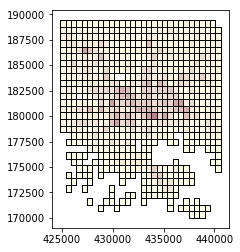

In [143]:
wsen_poly.plot(column='ALL', cmap=cmap)

In [145]:
wsen_poly

,geometry,ALL,description-DISORDERLY,description-COMMON ASSAULT,description-NARCOTICSOutside,description-SILENT ALARM,description-FAMILY DISTURB,description-BURGLARY,priority-Low,priority-Medium,priority-High,priority-Non-Emergency,priority-Emergency,priority-Out of Service
24,"POLYGON ((437983.5534564572 169997.5488773746,...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25,"POLYGON ((438507.7851064572 169997.5488773746,...",377,24.0,3.0,1.0,15.0,2.0,1.0,148.0,79.0,42.0,108.0,0.0,0.0
26,"POLYGON ((439032.0167564572 169997.5488773746,...",16,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,9.0,2.0,0.0,0.0
37,"POLYGON ((429071.615406458 170644.4697573747, ...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40,"POLYGON ((430644.3103564579 170644.4697573747,...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50,"POLYGON ((435886.6268564574 170644.4697573747,...",57,0.0,0.0,0.0,10.0,0.0,0.0,17.0,23.0,15.0,2.0,0.0,0.0
52,"POLYGON ((436935.0901564573 170644.4697573747,...",27,0.0,0.0,0.0,9.0,0.0,0.0,5.0,5.0,14.0,3.0,0.0,0.0
53,"POLYGON ((437459.3218064573 170644.4697573747,...",1179,15.0,4.0,1.0,15.0,2.0,0.0,188.0,926.0,47.0,18.0,0.0,0.0
54,"POLYGON ((437983.5534564572 170644.4697573747,...",231,17.0,5.0,0.0,38.0,1.0,13.0,73.0,73.0,51.0,34.0,0.0,0.0
55,"POLYGON ((438507.7851064572 170644.4697573747,...",15,2.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,7.0,2.0,0.0,0.0


0 0
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


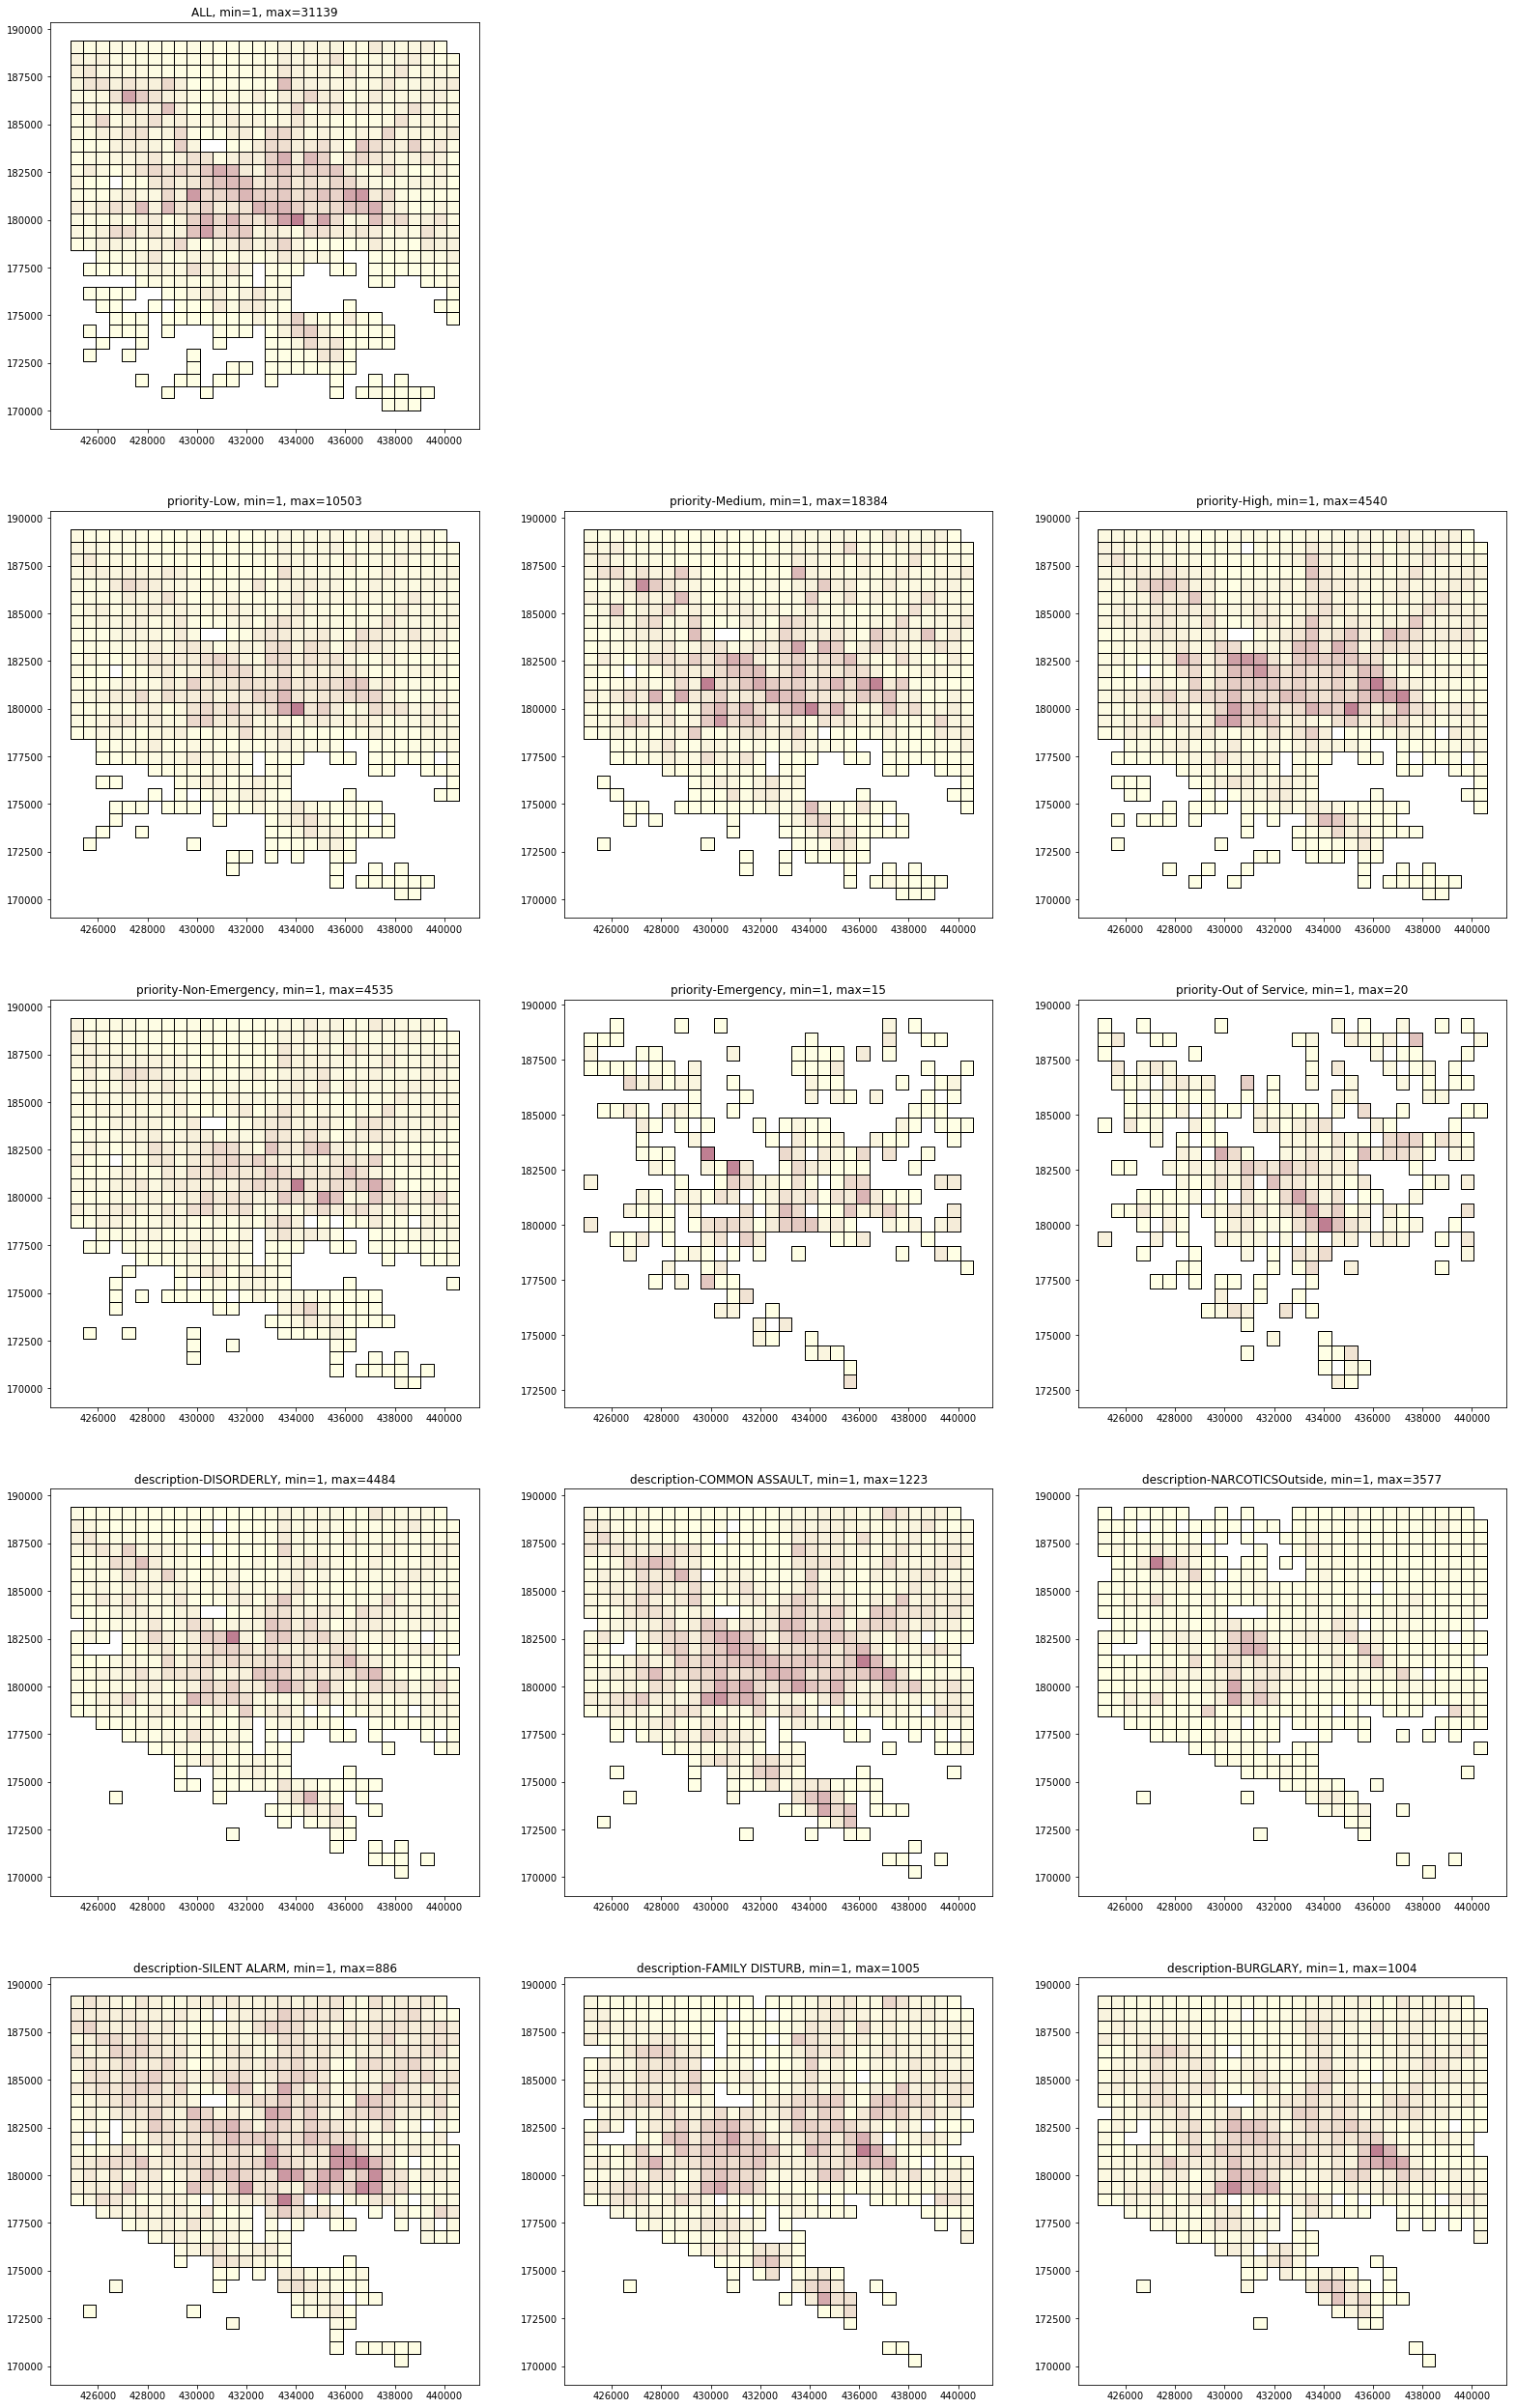

In [148]:

# fig, axes = pyplot.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(27, 18))
fig =pyplot.figure(figsize=(27,45))
for i, t in enumerate(['ALL'] + ['priority-'+t for t in priority_types]+['description-'+t for t in description_types]):
#     ax = axes[int(i/3)][i%3]
    if t!='ALL':
        i+=2
    print(int(i/3), i%3)
    ax = pyplot.subplot2grid((5,3), (int(i/3), i%3))
    mini, maxi = wsen_poly[wsen_poly[t]>0][t].min(), wsen_poly[t].max()
    ax.set_title('%s, min=%d, max=%d' % (t, mini, maxi))
    wsen_poly[wsen_poly[t]>0].plot(column=t, cmap=cmap, ax=ax, figsize=(9,9))
    